In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set global options for visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [23]:
# Load the dataset
file_path = "C:\\Users\\Laura Silola\\Desktop\\DATA SCIENCE\\Climate Change\\CO2 Emissions\\tidy_format_co2_emission_dataset.csv"
df = pd.read_csv(file_path)

# Display the first few rows
print("Dataset Preview:")
display(df.head())

# Dataset info
print("\nDataset Info:")
df.info()

# Check for missing or invalid data
print("\nMissing Values:")
print(df.isnull().sum())

# Ensure CO2EmissionRate is numeric
df["CO2EmissionRate (mt)"] = pd.to_numeric(df["CO2EmissionRate (mt)"], errors="coerce")
print("\nDataset After Conversion:")
print(df.describe())


Dataset Preview:


,Country,Year,CO2EmissionRate (mt)
0,Afghanistan,2021,8.35
1,Albania,2021,4.59
2,Algeria,2021,173
3,Angola,2021,24.45
4,Antigua and Barbuda,2021,0.78



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Country               5572 non-null   object
 1   Year                  5572 non-null   int64 
 2   CO2EmissionRate (mt)  5572 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.7+ KB

Missing Values:
Country                 0
Year                    0
CO2EmissionRate (mt)    0
dtype: int64

Dataset After Conversion:
              Year  CO2EmissionRate (mt)
count  5572.000000           5445.000000
mean   2003.714286              7.358246
std       8.460146             29.474644
min    1990.000000              0.000000
25%    1996.750000              0.700000
50%    2003.500000              2.900000
75%    2010.250000              7.500000
max    2021.000000            710.830000


In [25]:
# Handle missing values
df = df.dropna()
print(f"Dataset after dropping missing values: {df.shape}")

# Check for duplicate entries
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Save the cleaned dataset for future use
cleaned_file_path = "cleaned_co2_emission_dataset.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to {cleaned_file_path}")


Dataset after dropping missing values: (5445, 3)
Number of duplicate rows: 0
Cleaned dataset saved to cleaned_co2_emission_dataset.csv


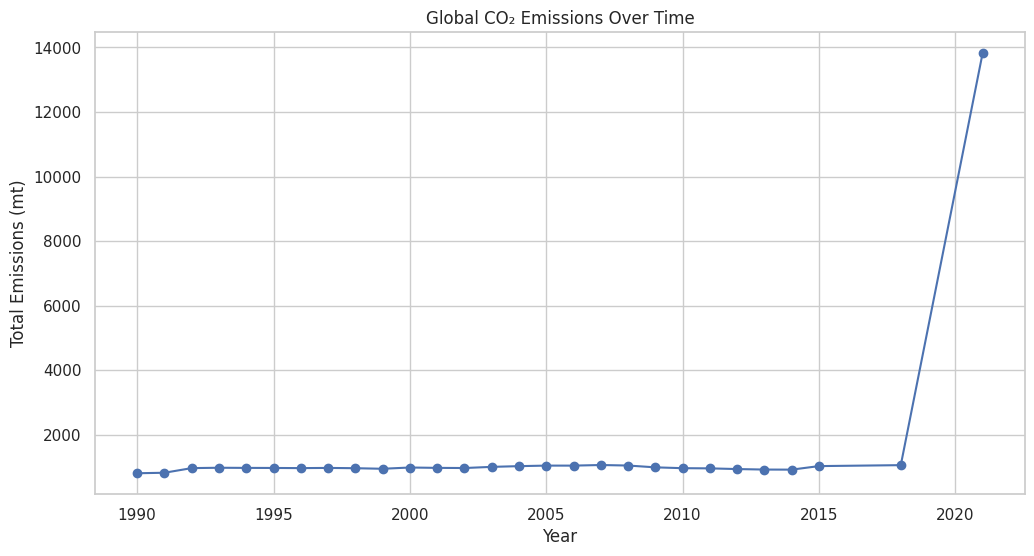

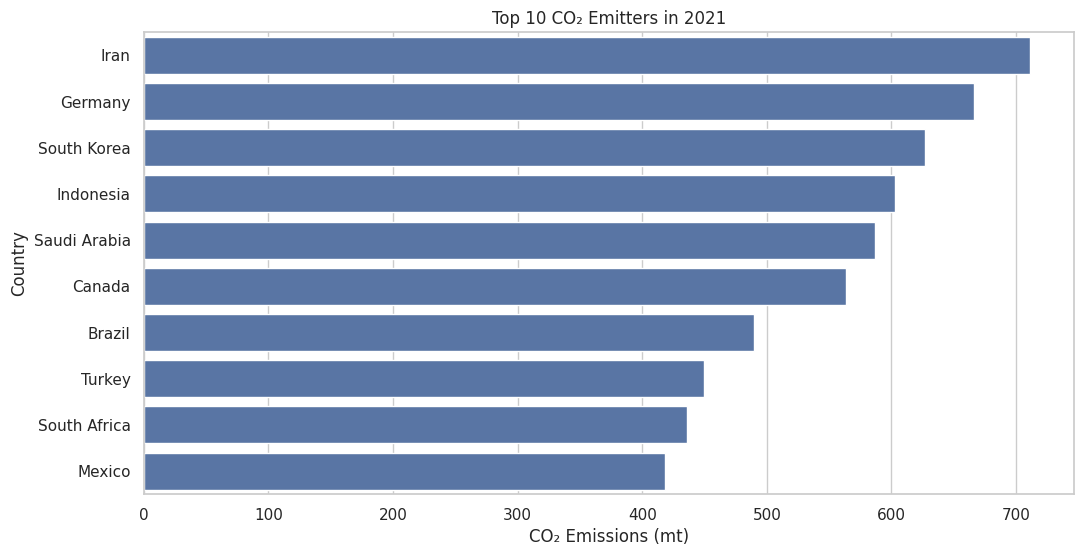

In [43]:
# Total CO2 emissions by year
yearly_emissions = df.groupby("Year")["CO2EmissionRate (mt)"].sum()

import matplotlib.pyplot as plt
# Change font to DejaVu Sans (supports most Unicode glyphs)
plt.rcParams['font.family'] = 'DejaVu Sans'

plt.plot(yearly_emissions.index, yearly_emissions.values, marker='o')
plt.title("Global CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Total Emissions (mt)")
plt.show()

# Top 10 emitters in the most recent year
latest_year = df["Year"].max()
top_emitters = df[df["Year"] == latest_year].sort_values("CO2EmissionRate (mt)", ascending=False).head(10)
sns.barplot(data=top_emitters, x="CO2EmissionRate (mt)", y="Country")  # Default color palette
plt.title(f"Top 10 CO₂ Emitters in {latest_year}")
plt.xlabel("CO₂ Emissions (mt)")
plt.ylabel("Country")
plt.show()


ADF Statistic: -3.6728751647488465
p-value: 0.004511276392715724
The series is stationary.
ADF Statistic: -3.6728751647488465
p-value: 0.004511276392715724
The series is stationary.


C:\Users\Laura Silola\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


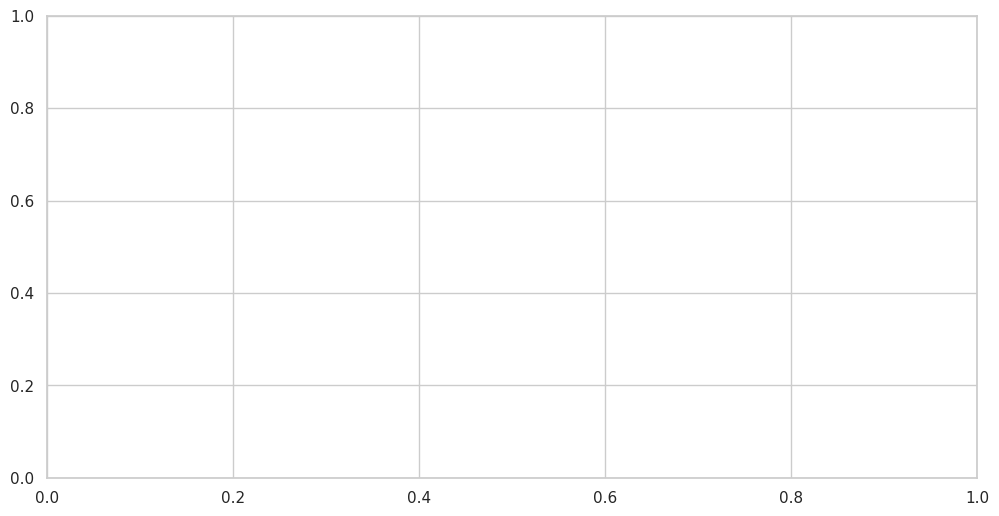

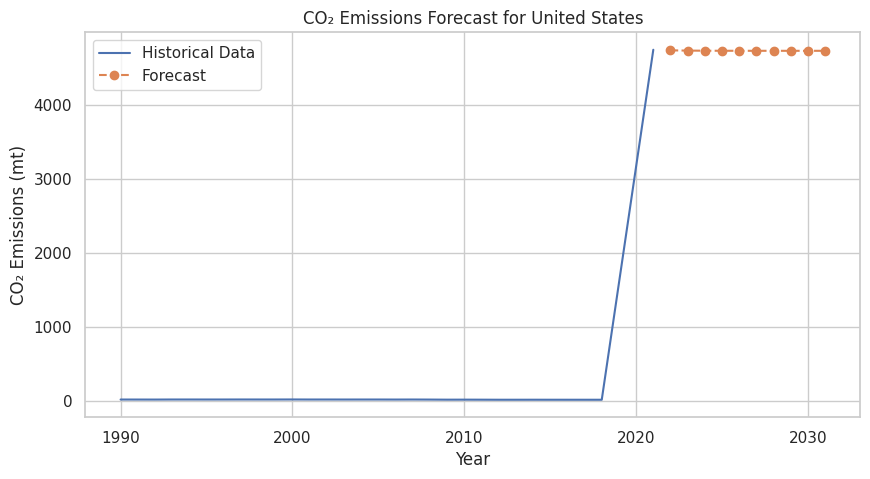

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Load your dataset
file_path = "C:\\Users\\Laura Silola\\Desktop\\DATA SCIENCE\\Climate Change\\CO2 Emissions\\tidy_format_co2_emission_dataset.csv"
df = pd.read_csv(file_path)

# Convert 'Year' to datetime format and set as index with frequency
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
df.index = df.index.to_period('Y')  # Set frequency to yearly

# Clean the 'CO2EmissionRate (mt)' column: replace '-' with NaN, remove commas, and convert to float
df['CO2EmissionRate (mt)'] = df['CO2EmissionRate (mt)'].replace('-', np.nan)
df['CO2EmissionRate (mt)'] = df['CO2EmissionRate (mt)'].str.replace(',', '', regex=False)

# Convert to numeric, coercing errors to NaN
df['CO2EmissionRate (mt)'] = pd.to_numeric(df['CO2EmissionRate (mt)'], errors='coerce')

# Filter for a single country's emissions (e.g., USA)
country = "United States"
country_data = df[df["Country"] == country].sort_values("Year")

# Ensure all values in the target column are numeric and drop NaNs
country_data = country_data.dropna(subset=["CO2EmissionRate (mt)"])

# Check for stationarity
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary. Differencing will be applied.")
        return True  # Indicates the need for differencing
    return False

# Check for stationarity
is_non_stationary = check_stationarity(country_data["CO2EmissionRate (mt)"])

# Apply differencing if necessary
if is_non_stationary:
    country_data['CO2EmissionRate (mt)'] = country_data['CO2EmissionRate (mt)'].diff().dropna()

# Recheck for stationarity after differencing
check_stationarity(country_data['CO2EmissionRate (mt)'].dropna())

# Fit ARIMA model
model = ARIMA(country_data["CO2EmissionRate (mt)"].dropna(), order=(1, 1, 1))  # Adjust orders as needed
fitted_model = model.fit()

# Predict future emissions
forecast_years = 10
forecast = fitted_model.forecast(steps=forecast_years)
forecast_years_range = range(country_data.index.year.max() + 1, country_data.index.year.max() + 1 + forecast_years)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(country_data.index.year, country_data["CO2EmissionRate (mt)"], label="Historical Data")
plt.plot(forecast_years_range, forecast, label="Forecast", linestyle="--", marker='o')
plt.title(f"CO₂ Emissions Forecast for {country}")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (mt)")
plt.legend()
plt.show()


ADF Statistic: 1.0594792371359523
p-value: 0.9948555162107495
Training data is non-stationary, applying differencing...
ADF Statistic: -4.94855547892872
p-value: 2.802885677589175e-05


C:\Users\Laura Silola\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model Performance:
MAE: 947.47, RMSE: 2118.15


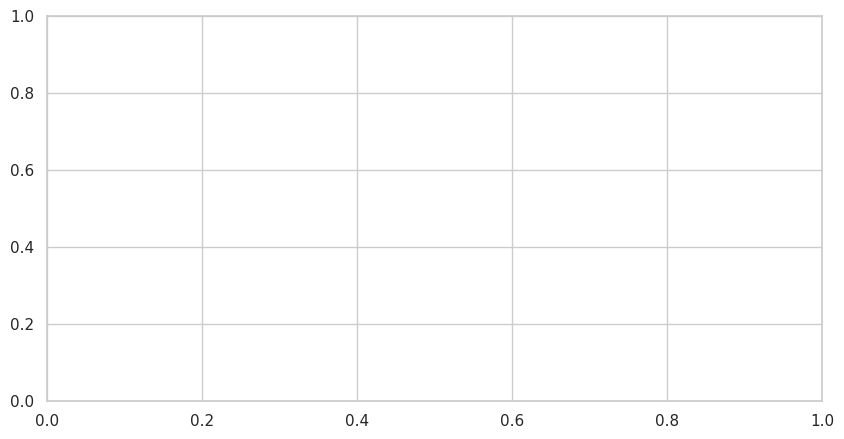

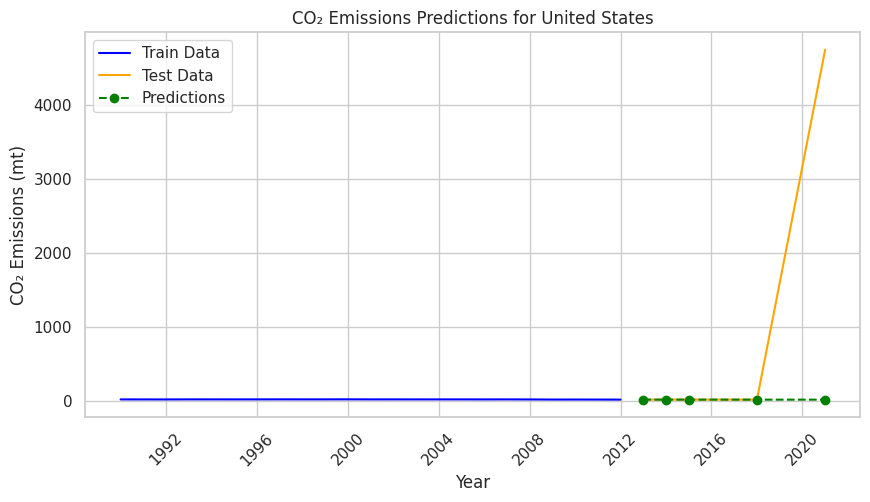

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your dataset
file_path = "C:\\Users\\Laura Silola\\Desktop\\DATA SCIENCE\\Climate Change\\CO2 Emissions\\tidy_format_co2_emission_dataset.csv"
df = pd.read_csv(file_path)

# Convert 'Year' to datetime format and set as index with frequency
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
df.index = df.index.to_period('Y')  # Set frequency to yearly

# Clean the 'CO2EmissionRate (mt)' column: replace '-' with NaN, remove commas, and convert to float
df['CO2EmissionRate (mt)'] = df['CO2EmissionRate (mt)'].replace('-', np.nan)
df['CO2EmissionRate (mt)'] = df['CO2EmissionRate (mt)'].str.replace(',', '', regex=False)
df['CO2EmissionRate (mt)'] = pd.to_numeric(df['CO2EmissionRate (mt)'], errors='coerce')

# Filter for a single country's emissions (e.g., USA)
country = "United States"
country_data = df[df["Country"] == country].sort_values("Year")

# Drop NaNs in the target column
country_data = country_data.dropna(subset=["CO2EmissionRate (mt)"])

# Check for stationarity of the training data
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] <= 0.05  # Return True if stationary

# Split into training and test sets
train = country_data["CO2EmissionRate (mt)"][:-5]  # Last 5 years for testing
test = country_data["CO2EmissionRate (mt)"][-5:]

# Check for stationarity in training data
if not check_stationarity(train):
    print("Training data is non-stationary, applying differencing...")
    train_diff = train.diff().dropna()
    check_stationarity(train_diff)  # Recheck after differencing
else:
    train_diff = train

# Fit ARIMA model
model = ARIMA(train_diff, order=(1, 0, 1))  # Use differenced data
fitted_model = model.fit()

# Predictions on the original scale
predictions = fitted_model.forecast(steps=len(test))
predictions = predictions.cumsum() + train.iloc[-1]  # Reversing the differencing

# Calculate error metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"Model Performance:\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Convert index to datetime for plotting
train_index = train.index.to_timestamp()
test_index = test.index.to_timestamp()
predictions_index = test.index.to_timestamp()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train_index, train, label="Train Data", color='blue')
plt.plot(test_index, test, label="Test Data", color='orange')
plt.plot(predictions_index, predictions, label="Predictions", linestyle="--", marker='o', color='green')
plt.title(f"CO₂ Emissions Predictions for {country}")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (mt)")
plt.legend()
plt.xticks(rotation=45)
plt.show()
